# Imports and Setup:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import scipy

from glob import glob

import matplotlib.pyplot as plt

from skimage import transform
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import datetime
import os

from imageio import imread

Using TensorFlow backend.


# load_data:

In [2]:
def load_data(dataset_name, batch_size=1, is_val=False):
    data_type = "train" if not is_val else "val"
    path = glob('../input/%s/%s/%s/*' % (dataset_name, dataset_name, data_type))

    batch_images = np.random.choice(path, size=batch_size)
    img_res = (128, 128)
    imgs_A = []
    imgs_B = []
    for img_path in batch_images:
        img = imread(img_path)
        h, w, _ = img.shape
        _w = int(w / 2)
        if dataset_name in ["edges2shoes", "maps"]:
            img_A, img_B = img[:, _w:, :], img[:, :_w, :]
        else:
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]
        img_A = transform.resize(img_A, img_res)
        img_B = transform.resize(img_B, img_res)
        if not is_val and np.random.random() < 0.5:
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)
        imgs_A.append(img_A)
        imgs_B.append(img_B)
    imgs_A = np.array(imgs_A) / 127.5 - 1.
    imgs_B = np.array(imgs_B) / 127.5 - 1.
    return imgs_A, imgs_B

# load_batch:

In [3]:
def load_batch( dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('../input/%s/%s/%s/*' % (dataset_name,dataset_name, data_type))

        
        n_batches=batch_size
        img_res=(128,128)
        for i in range(n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :] 
                else:  
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
                
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B
def imread(path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

# Generator:

In [4]:
def build_generator():
    def conv2d(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    d0 = Input(shape=img_shape)
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf * 2)
    d3 = conv2d(d2, gf * 4)
    d4 = conv2d(d3, gf * 8)
    d5 = conv2d(d4, gf * 8)
    d6 = conv2d(d5, gf * 8)
    d7 = conv2d(d6, gf * 8)
    u1 = deconv2d(d7, d6, gf * 8)
    u2 = deconv2d(u1, d5, gf * 8)
    u3 = deconv2d(u2, d4, gf * 8)
    u4 = deconv2d(u3, d3, gf * 4)
    u5 = deconv2d(u4, d2, gf * 2)
    u6 = deconv2d(u5, d1, gf)
    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    return Model(d0, output_img)

# Discriminator:

In [5]:
def build_discriminator():
    def d_layer(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)
    combined_imgs = Concatenate(axis=-1)([img_A, img_B])
    d1 = d_layer(combined_imgs, df, bn=False)
    d2 = d_layer(d1, df * 2)
    d3 = d_layer(d2, df * 4)
    d4 = d_layer(d3, df * 8)
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    return Model([img_A, img_B], validity)

### Setting up the input shape and optimizer & Building and compiling the models:


In [6]:
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)
gf = 64
df = 64
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
generator = build_generator()
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)
fake_A = generator(img_B)
discriminator.trainable = False
valid = discriminator([fake_A, img_B])
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

In [7]:
def show_images(dataset_name, epoch, batch_i):
    r, c = 3, 3
    imgs_A, imgs_B = load_data(dataset_name, batch_size=3, is_val=True)
    fake_A = generator.predict(imgs_B)
    gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])
    gen_imgs = 0.5 * gen_imgs + 0.5
    titles = ['Input', 'Output', 'Ground Truth']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[i])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

# Training function:

In [8]:
def train(dataset_name, epochs, batch_size=1, show_interval=10):
    start_time = datetime.datetime.now()
    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)
    for epoch in range(epochs):
        for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name, batch_size)):
            fake_A = generator.predict(imgs_B)
            d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
            d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
            elapsed_time = datetime.datetime.now() - start_time
        if epoch % 10 == 0:
            print("[Epoch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" %
                  (epoch, epochs, d_loss[0], 100 * d_loss[1], g_loss[0], elapsed_time))
        if epoch % show_interval == 0:
            show_images(dataset_name, epoch, batch_i)

[Epoch 0/50] [D loss: 0.396203, acc:  54%] [G loss: 24.742083] time: 0:00:38.267315


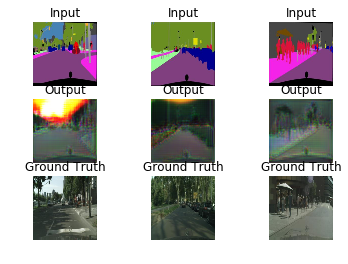

[Epoch 10/50] [D loss: 0.403096, acc:  57%] [G loss: 18.573973] time: 0:04:54.837506


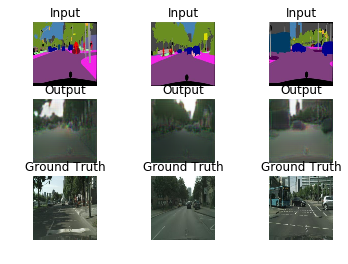

[Epoch 20/50] [D loss: 0.209025, acc:  67%] [G loss: 16.076872] time: 0:09:11.809215


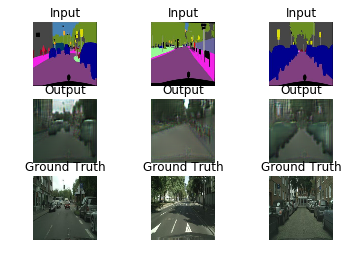

[Epoch 30/50] [D loss: 0.137265, acc:  85%] [G loss: 13.887999] time: 0:13:27.634520


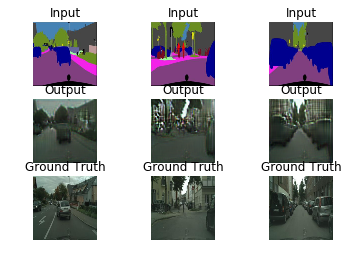

[Epoch 40/50] [D loss: 0.160753, acc:  79%] [G loss: 12.809147] time: 0:17:44.067309


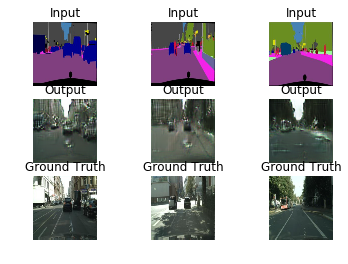

In [9]:
train("cityscapes",epochs=50, batch_size=32, show_interval=10)

[Epoch 0/50] [D loss: 0.335585, acc:  42%] [G loss: 22.821291] time: 0:00:30.354340


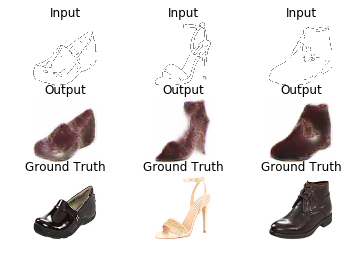

[Epoch 10/50] [D loss: 0.203647, acc:  70%] [G loss: 13.291032] time: 0:04:49.640040


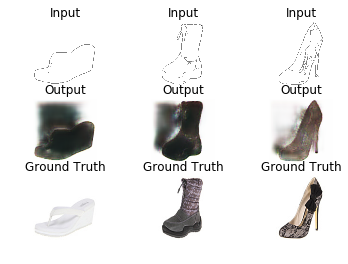

[Epoch 20/50] [D loss: 0.328633, acc:  43%] [G loss: 11.146451] time: 0:09:10.127174


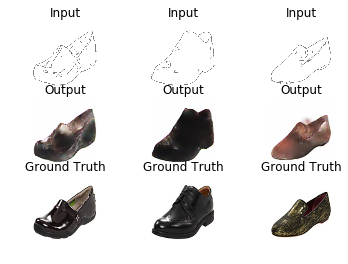

[Epoch 30/50] [D loss: 0.194349, acc:  73%] [G loss: 8.951402] time: 0:13:30.509368


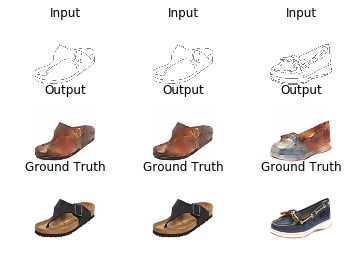

[Epoch 40/50] [D loss: 0.226704, acc:  66%] [G loss: 9.188933] time: 0:17:50.462690


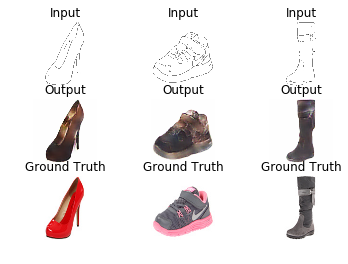

In [10]:
train("edges2shoes",epochs=50, batch_size=32, show_interval=10)